In [1]:
import numpy as np
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline 

In [2]:
for p in [np, pd, sklearn, sns]:
    print (p.__name__, p.__version__)

numpy 1.14.3
pandas 0.23.0
sklearn 0.19.1
seaborn 0.8.1


In [3]:
def downcast_dtypes(df):    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [4]:
sales = pd.read_csv('Data/sales_train.csv')
shops = pd.read_csv('Data/shops.csv')
items = pd.read_csv('Data/items.csv')
item_cats = pd.read_csv('Data/item_categories.csv')
test = pd.read_csv('Data/test.csv')

In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
test_data = test.copy()
sales_in_month = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()
sales_by_item_id_for_last_val = sales_in_month.groupby('item_id').last()
def fill_price(item_id):
    if item_id in sales_by_item_id_for_last_val.index:
        return sales_by_item_id_for_last_val.loc[item_id]['item_price']
    else:
        return sales_by_item_id_for_last_val['item_price'].median()
test_data['date_block_num'] = 34
test_data['item_price'] = test_data['item_id'].apply(fill_price)
test_data['item_cnt_day'] = 0

In [10]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [11]:
test_data = test_data.drop(columns=['ID'])
test_data.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,5,5037,34,1499.0,0
1,5,5320,34,299.0,0
2,5,5233,34,1199.0,0
3,5,5232,34,1199.0,0
4,5,5268,34,299.0,0


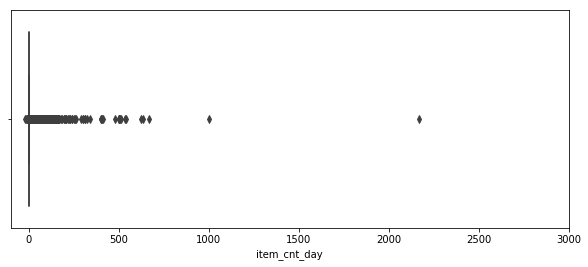

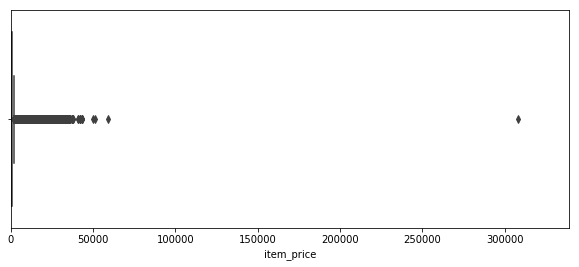

In [12]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.1)
sns.boxplot(x=sales.item_price)

In [13]:
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<1001]

In [14]:
sales.loc[sales.shop_id == 0, "shop_id"] = 57
test.loc[test.shop_id == 0 , "shop_id"] = 57
sales.loc[sales.shop_id == 1, "shop_id"] = 58
test.loc[test.shop_id == 1 , "shop_id"] = 58
sales.loc[sales.shop_id == 11, "shop_id"] = 10
test.loc[test.shop_id == 11, "shop_id"] = 10
sales.loc[sales.shop_id == 40, "shop_id"] = 39
test.loc[test.shop_id == 40, "shop_id"] = 39

In [15]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_cats, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
testD = test_data.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_cats, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [16]:
train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства
5,10.01.2013,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,"Москва ТРК ""Атриум""",Музыка - Музыкальное видео
6,02.01.2013,0,25,2565,549.00,1.0,DEEP PURPLE Stormbringer (фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства
7,04.01.2013,0,25,2572,239.00,1.0,DEFTONES Koi No Yokan,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
8,11.01.2013,0,25,2572,299.00,1.0,DEFTONES Koi No Yokan,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства
9,03.01.2013,0,25,2573,299.00,3.0,DEL REY LANA Born To Die,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства


In [17]:
testD.head()

,shop_id,item_id,date_block_num,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,5,5037,34,1499.0,0,"NHL 15 [PS3, русские субтитры]",19,"Вологда ТРЦ ""Мармелад""",Игры - PS3
1,5,5320,34,299.0,0,ONE DIRECTION Made In The A.M.,55,"Вологда ТРЦ ""Мармелад""",Музыка - CD локального производства
2,5,5233,34,1199.0,0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,"Вологда ТРЦ ""Мармелад""",Игры - PS3
3,5,5232,34,1199.0,0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,"Вологда ТРЦ ""Мармелад""",Игры - XBOX 360
4,5,5268,34,299.0,0,"Need for Speed [PS4, русская версия]",20,"Вологда ТРЦ ""Мармелад""",Игры - PS4


In [18]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [19]:
train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,revenue
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,999.00
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,"Москва ТРК ""Атриум""",Музыка - Музыкальное видео,349.00
6,02.01.2013,0,25,2565,549.00,1.0,DEEP PURPLE Stormbringer (фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,549.00
7,04.01.2013,0,25,2572,239.00,1.0,DEFTONES Koi No Yokan,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,239.00
8,11.01.2013,0,25,2572,299.00,1.0,DEFTONES Koi No Yokan,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,299.00
9,03.01.2013,0,25,2573,299.00,3.0,DEL REY LANA Born To Die,55,"Москва ТРК ""Атриум""",Музыка - CD локального производства,897.00


In [20]:
train = train.query('item_price > 0')

In [21]:
train_monthly = train[['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
train_monthly34 = testD[['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [22]:
train_monthly.head()

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
0,0,59,37,22154,999.00,1.0
1,0,25,58,2552,899.00,1.0
2,0,25,58,2552,899.00,-1.0
3,0,25,58,2554,1709.05,1.0
4,0,25,56,2555,1099.00,1.0


In [23]:
train_monthly34.head()

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
0,34,5,19,5037,1499.0,0
1,34,5,55,5320,299.0,0
2,34,5,19,5233,1199.0,0
3,34,5,23,5232,1199.0,0
4,34,5,20,5268,299.0,0


In [25]:
# Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [26]:
train_monthly.head()

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.00,1532.857143,9.0,1.285714,7
1,0,2,2,5573,1848.00,924.000000,2.0,1.000000,2
2,0,2,2,5575,3820.02,955.005000,4.0,1.000000,4
3,0,2,2,5576,7470.00,2490.000000,3.0,1.000000,3
4,0,2,2,5632,2390.00,2390.000000,1.0,1.000000,1


In [27]:
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

In [28]:
train_monthly.head()

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
0,0,2,2,5572,10730.00,1532.857143,9.0,1.285714,7,2013,0
1,0,2,2,5573,1848.00,924.000000,2.0,1.000000,2,2013,0
2,0,2,2,5575,3820.02,955.005000,4.0,1.000000,4,2013,0
3,0,2,2,5576,7470.00,2490.000000,3.0,1.000000,3,2013,0
4,0,2,2,5632,2390.00,2390.000000,1.0,1.000000,1,2013,0


In [29]:
train_monthly['month'].max()

11

In [30]:
monthly2013_mean=train_monthly[train_monthly.year <= 2013][['shop_id','item_id','transactions','month']].sort_values(['month','item_id', 'shop_id'])
monthly2014_mean=train_monthly[train_monthly.year < 2014][['shop_id','item_id','transactions','month']].sort_values(['month','item_id', 'shop_id'])
monthly2015_mean=train_monthly[train_monthly.year < 2015][['shop_id','item_id','transactions','month']].sort_values(['month','item_id', 'shop_id'])

In [31]:
monthly2013_mean = monthly2013_mean.groupby(['month','item_id', 'shop_id']).mean().reset_index()
monthly2014_mean = monthly2014_mean.groupby(['month','item_id', 'shop_id']).mean().reset_index()
monthly2015_mean = monthly2015_mean.groupby(['month','item_id', 'shop_id']).mean().reset_index()

In [32]:
monthly2015_mean.head()


,month,item_id,shop_id,transactions
0,0,19,25,1.0
1,0,27,2,1.0
2,0,27,10,1.0
3,0,27,17,1.0
4,0,27,19,1.0


In [33]:
monthly2013_mean['year']=2013
monthly2014_mean['year']=2014
monthly2015_mean['year']=2015

In [34]:
monthly2015_mean.head()

,month,item_id,shop_id,transactions,year
0,0,19,25,1.0,2015
1,0,27,2,1.0,2015
2,0,27,10,1.0,2015
3,0,27,17,1.0,2015
4,0,27,19,1.0,2015


In [35]:
mean_values = monthly2013_mean

In [36]:
mean_values = mean_values.append(monthly2014_mean)
mean_values = mean_values.append(monthly2015_mean)

In [37]:
mean_values['year'].unique()

array([2013, 2014, 2015], dtype=int64)

In [38]:
mean_values.columns = ['month','item_id','shop_id','mean_tran','year']
mean_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2509790 entries, 0 to 1134343
Data columns (total 5 columns):
month        int64
item_id      int64
shop_id      int64
mean_tran    float64
year         int64
dtypes: float64(1), int64(4)
memory usage: 114.9 MB


In [39]:
train_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1608271 entries, 0 to 1608270
Data columns (total 11 columns):
date_block_num      1608271 non-null int64
shop_id             1608271 non-null int64
item_category_id    1608271 non-null int64
item_id             1608271 non-null int64
item_price          1608271 non-null float64
mean_item_price     1608271 non-null float64
item_cnt            1608271 non-null float64
mean_item_cnt       1608271 non-null float64
transactions        1608271 non-null int64
year                1608271 non-null int64
month               1608271 non-null int64
dtypes: float64(4), int64(7)
memory usage: 147.2 MB


In [40]:
train_monthly=train_monthly.merge(mean_values, on=['month','year','shop_id','item_id'])

In [41]:
train_monthly.head()

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,mean_tran
0,0,2,2,5572,10730.00,1532.857143,9.0,1.285714,7,2013,0,7.0
1,0,2,2,5573,1848.00,924.000000,2.0,1.000000,2,2013,0,2.0
2,0,2,2,5575,3820.02,955.005000,4.0,1.000000,4,2013,0,4.0
3,0,2,2,5576,7470.00,2490.000000,3.0,1.000000,3,2013,0,3.0
4,0,2,2,5632,2390.00,2390.000000,1.0,1.000000,1,2013,0,1.0


In [42]:
trainSet = train_monthly[train_monthly.date_block_num < 33]
ValidationSet = train_monthly[train_monthly.date_block_num == 33]

In [43]:
X_train_features = trainSet.drop('item_cnt', 1)
y_train = trainSet['item_cnt']
X_cv_features = ValidationSet.drop('item_cnt', 1)
y_cv = ValidationSet['item_cnt']

In [44]:
target_range = [0, 20]
target_range

[0, 20]

In [49]:
lr = LinearRegression()
lr.fit(X_train_features.values, y_train)
lr_validation = lr.predict(X_cv_features.values).clip(*target_range)
print ('Coefficients: ', lr.coef_)
print("Residual sum of squares: %.2f"
      % np.mean((lr_validation - y_cv) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lr.score(X_cv_features, y_cv))

Coefficients:  [ 7.40690263e-03 -1.57849014e-03  1.46937002e-02  4.38215772e-05
 -1.64964856e-04  2.64052190e-04  6.58724166e+00  2.16581387e+00
  1.11255039e-03 -5.94370210e-03 -2.79240187e-02]
Residual sum of squares: 96.26
Variance score: 0.59


In [46]:
#sample_submission = pd.read_csv('Data/sample_submission.csv')
#sample_submission.head()

214200

In [58]:
train_monthly34['year'] = 2015
train_monthly34['month'] = 10
train_monthly34 = train_monthly34.sort_values('item_id')
train_monthly34=train_monthly34.merge(mean_values, on=['month','year','shop_id','item_id'])
print(len(train_monthly34))
train_monthly34

419411


,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,mean_tran_x,mean_tran_y,mean_tran_x,mean_tran_y
0,0,26,19,27,2499.0,2499.0,1.0,1.000000,1,2015,10,1.0,1.0,1.0,1.0
1,10,26,19,27,1198.0,1198.0,1.0,1.000000,1,2015,10,1.0,1.0,1.0,1.0
2,1,21,19,27,1998.0,1998.0,1.0,1.000000,1,2015,10,1.0,1.0,1.0,1.0
3,10,21,19,27,1198.0,1198.0,1.0,1.000000,1,2015,10,1.0,1.0,1.0,1.0
4,8,54,30,28,498.0,249.0,2.0,1.000000,2,2015,10,2.0,2.0,1.0,1.0
5,10,54,30,28,199.0,199.0,1.0,1.000000,1,2015,10,1.0,1.0,1.0,1.0
6,9,54,30,28,139.3,139.3,1.0,1.000000,1,2015,10,1.0,1.0,1.0,1.0
7,10,37,30,28,199.0,199.0,1.0,1.000000,1,2015,10,1.0,1.0,1.0,1.0
8,10,16,30,28,398.0,199.0,2.0,1.000000,2,2015,10,2.0,2.0,2.0,2.0
9,10,6,30,28,199.0,199.0,1.0,1.000000,1,2015,10,1.0,1.0,1.0,1.0
